In [43]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [44]:
def cdf(image):
    count = np.zeros(256, dtype = int)
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            count[image[i][j]] += 1
            
    for i in range(1, 256):
        count[i] = count[i-1] + count[i]

    return count / (image.shape[0] * image.shape[1])

In [45]:
def make_hsi(image):
    h = np.zeros((image.shape[0], image.shape[1]), dtype = float)
    s = np.zeros((image.shape[0], image.shape[1]), dtype = float)
    i = np.zeros((image.shape[0], image.shape[1]), dtype = float)
      
    Rn = image[:, :, 0] / 255.0
    Gn = image[:, :, 1] / 255.0
    Bn = image[:, :, 2] / 255.0

    for r in range(image.shape[0]):
        for c in range(image.shape[1]):
            # Intensity
            i[r][c] = (Rn[r][c] + Gn[r][c] + Bn[r][c]) / 3
                
            # Saturation
            if (i[r][c] == 0): i[r][c] += 0.0001
            s[r][c] = 1 - (np.min([Rn[r][c], Gn[r][c], Bn[r][c]]) / i[r][c])

            # Hue
            temp = (2 * np.sqrt((Rn[r][c] - Gn[r][c]) ** 2 + (Rn[r][c] - Bn[r][c]) * (Gn[r][c] - Bn[r][c])))
            if (temp == 0): temp += 0.0001
            angle = (2 * Rn[r][c] - Gn[r][c] - Bn[r][c]) / temp
            angle = np.clip(angle, -1, 1)   
            h[r][c] = np.arccos(angle) / (2 * np.pi)
            if Bn[r][c] > Gn[r][c]: h[r][c] = 1 - h[r][c]

    h = np.clip(h, 0, 1)
    s = np.clip(s, 0, 1)
    i = np.clip(i, 0, 1)

    return np.stack([h, s, i], axis=-1)

In [46]:
def hsi_to_rgb(image):
        newR = np.zeros((image.shape[0], image.shape[1]), dtype=float)
        newG = np.zeros((image.shape[0], image.shape[1]), dtype=float)
        newB = np.zeros((image.shape[0], image.shape[1]), dtype=float)
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                H = image[i][j][0] * 2 * np.pi  
                S = image[i][j][1]
                I = image[i][j][2] 
                
                # 0 <= H < 2π/3
                if 0 <= H < 2 * np.pi/3:
                    newB[i][j] = I * (1 - S)
                    temp = np.cos(np.pi/3 - H)
                    if temp == 0: temp += 0.0001
                    newR[i][j] = I * (1 + (S * np.cos(H)) / temp)
                    newG[i][j] = 3 * I - (newR[i][j] + newB[i][j])
                
                # 2π/3 <= H < 4π/3
                elif 2 * np.pi/3 <= H < 4 * np.pi/3:
                    H = H - 2 * np.pi/3
                    newR[i][j] = I * (1 - S)
                    temp = np.cos(np.pi/3 - H)
                    if temp == 0: temp += 0.0001
                    newG[i][j] = I * (1 + (S * np.cos(H)) / temp)
                    newB[i][j] = 3 * I - (newR[i][j] + newG[i][j])
                
                # 4π/3 <= H < 2π
                elif 4 * np.pi/3 <= H < 2 * np.pi:
                    H = H - 4 * np.pi/3
                    newG[i][j] = I * (1 - S)
                    temp = np.cos(np.pi/3 - H)
                    if temp == 0: temp += 0.0001
                    newB[i][j] = I * (1 + (S * np.cos(H)) / temp)
                    newR[i][j] = 3 * I - (newG[i][j] + newB[i][j])

        newR = (np.clip(newR, 0, 1) * 255).astype(np.uint8)
        newG = (np.clip(newG, 0, 1) * 255).astype(np.uint8)
        newB = (np.clip(newB, 0, 1) * 255).astype(np.uint8)

        return np.stack([newR, newG, newB], axis=-1)

In [47]:
def histogram_equalization(image):
    hsi_image = make_hsi(image)
    CDF = cdf((hsi_image[:, :, 2] * 255).astype(np.uint8))
    
    new_i = CDF[(hsi_image[:, :, 2] * 255).astype(np.uint8)]

    hsi_image[:, :, 2] = new_i

    return hsi_to_rgb(hsi_image)

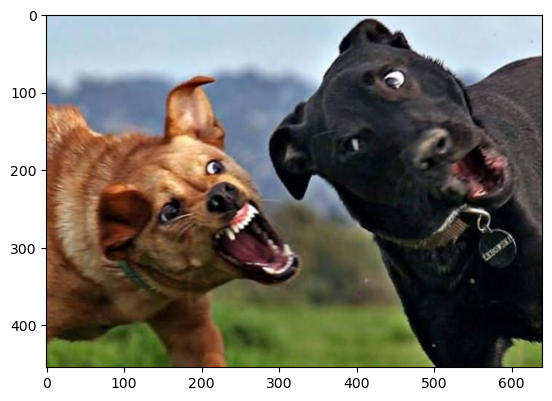

In [48]:
raw_image = cv2.imread('image.jpg')
image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

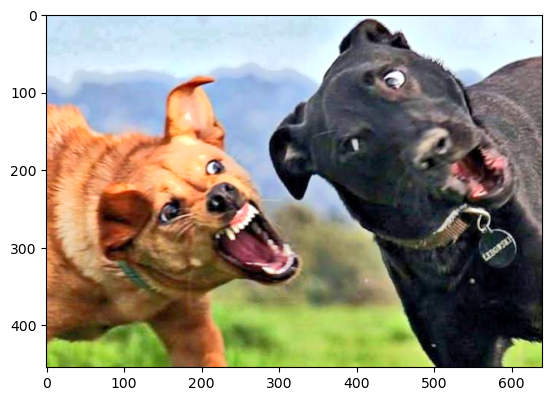

In [49]:
histogram_equalized_image = histogram_equalization(image)
plt.imshow(histogram_equalized_image)

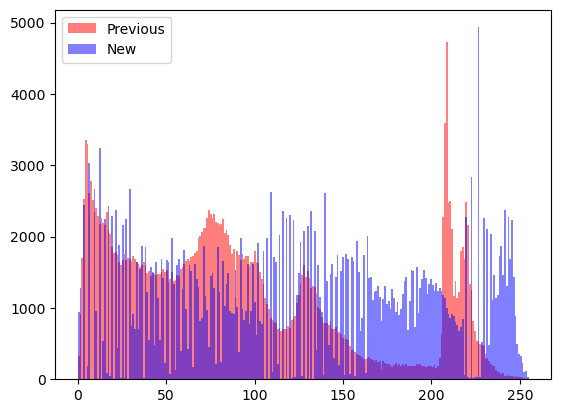

In [55]:
plt.hist((make_hsi(image)[:, :, 2] * 255).flatten(), bins=256, color='red', alpha=0.5, label='Previous')
plt.hist((make_hsi(histogram_equalized_image)[:, :, 2] * 255).flatten(), bins=256, color='blue', alpha=0.5, label='New')
plt.legend()
plt.show()